<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.16/QuestionAnsweringTransformersFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question Answering**

주어진 글로 부터 질문을 하면 답을 찾아주는 모델

참조 : [Hugging Face](https://huggingface.co/tasks/question-answering)


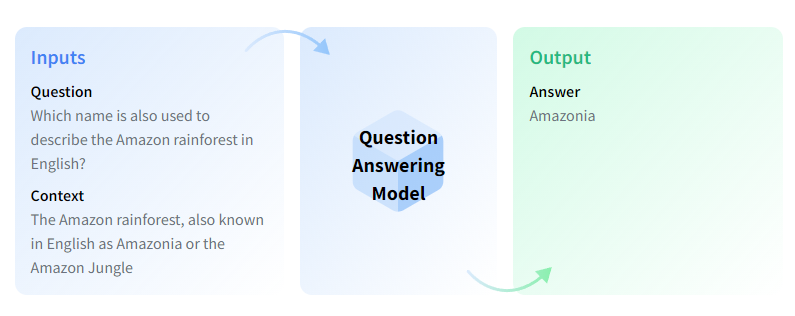

In [ ]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


**SQuAD 데이터 세트**

[데이터 세트 설명 참조](https://rajpurkar.github.io/SQuAD-explorer/)




In [ ]:
from datasets import load_dataset

squad = load_dataset("squad", split="train[:5000]")
print(squad)
print(squad[0])
squad = squad.train_test_split(test_size=0.2)
squad["train"][0]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5000
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects

{'id': '573344334776f419006607d2',
 'title': 'Genocide',
 'context': 'The word genocide was later included as a descriptive term to the process of indictment, but not yet as a formal legal term According to Lemming, genocide was defined as "a coordinated strategy to destroy a group of people, a process that could be accomplished through total annihilation as well as strategies that eliminate key elements of the group\'s basic existence, including language, culture, and economic infrastructure.” He created a concept of mobilizing much of the international relations and community, to working together and preventing the occurrence of such events happening within history and the international society. Australian anthropologist Peg LeVine coined the term "ritualcide" to describe the destruction of a group\'s cultural identity without necessarily destroying its members.',
 'question': 'Prior to being a formal legal term, how was the word "genocide" used in an indictment scenario?',
 'answers

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)
print(tokenized_squad)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1000
    })
})


In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_qa_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    #push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Number of trainable parameters = 66364418


Epoch,Training Loss,Validation Loss
1,No log,2.467091
2,2.746600,1.835582
3,2.746600,1.749424


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_qa_model/checkpoint-500
Configuration saved in my_awesome_qa_model/checkpoint-500/config.json
Model weights saved in my_awesome_qa_model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in my_awesome_qa_model/checkpoint-500/tokenizer_config.json
Special tokens file saved in my_awesome_qa_model/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=750, training_loss=2.3054554443359376, metrics={'train_runtime': 452.1995, 'train_samples_per_second': 26.537, 'train_steps_per_second': 1.659, 'total_flos': 1175877900288000.0, 'train_loss': 2.3054554443359376, 'epoch': 3.0})

In [ ]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [ ]:
device = "cuda:0"
inputs = tokenizer(question, context, return_tensors="pt").to(device)

In [ ]:
import torch

outputs = model(**inputs)

In [ ]:
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

In [ ]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'176 billion parameters and can generate text in 46 languages natural languages and 13'